In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
import json

In [43]:
# Load the image
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/train/46.png')

# Increase the size of the image
height = 64
if image.shape[0] < height:
    ratio = height / image.shape[0]
    width = int(image.shape[1] * ratio)
    image = cv2.resize(image, (width, height))

In [44]:
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply median blur to reduce noise
blurred = cv2.medianBlur(gray, 3)

# Apply adaptive thresholding to enhance the contrast
th = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

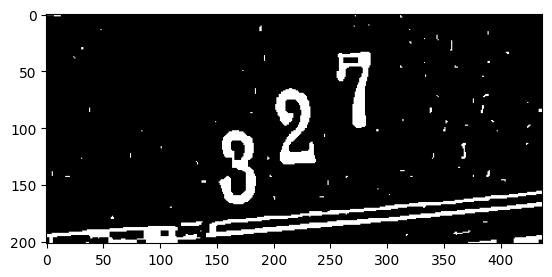

In [45]:
# Perform morphological operations to fill gaps and smooth the image
kernel = np.ones((3, 3), np.uint8)
th = cv2.erode(th, kernel, iterations=1)
th = cv2.GaussianBlur(th, (5, 5), 3)
th = cv2.erode(th, kernel, iterations=2)
ret, th = cv2.threshold(th, 4, 255, cv2.THRESH_BINARY)

# Display
plt.imshow(cv2.cvtColor(th, cv2.COLOR_BGR2RGB))
plt.show()

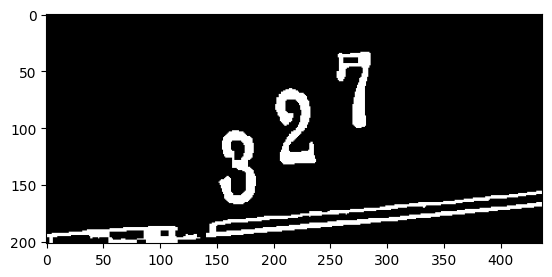

In [46]:
# Calculate the total number of pixels in the image
total_pixels = image.shape[0] * image.shape[1]

# Set the minimum and maximum area based on a percentage of the total number of pixels
min_area_percent = 0.002  
max_area_percent = 0.3   
min_area = int(total_pixels * min_area_percent)
max_area = int(total_pixels * max_area_percent)

# Find connected components and filter based on area
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if area < min_area or area > max_area:
        th[labels == i] = 0

# Display
plt.imshow(cv2.cvtColor(th, cv2.COLOR_BGR2RGB))
plt.show()

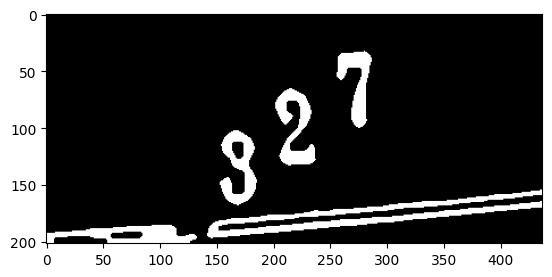

In [47]:
# Perform morphological operations
th = cv2.GaussianBlur(th, (5, 5), 3)
th = cv2.erode(th, kernel, iterations=2)
th = cv2.GaussianBlur(th, (5, 5), 3)
ret, th = cv2.threshold(th, 4, 255, cv2.THRESH_BINARY)
th = cv2.erode(th, kernel, iterations=1)
th = cv2.GaussianBlur(th, (5, 5), 3)
th = cv2.erode(th, kernel, iterations=1)
ret, th = cv2.threshold(th, 60, 255, cv2.THRESH_BINARY)

# Display
plt.imshow(cv2.cvtColor(th, cv2.COLOR_BGR2RGB))
plt.show()

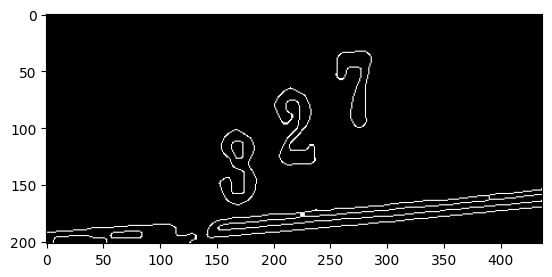

In [48]:
# Detect Edges 
edges = cv2.Canny(th, 100, 100)
edges = cv2.GaussianBlur(edges, (3,3), 1)
edges = cv2.erode(edges, kernel, iterations=1)
ret, edges = cv2.threshold(edges, 18, 255, cv2.THRESH_BINARY)

# Display
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
plt.show()

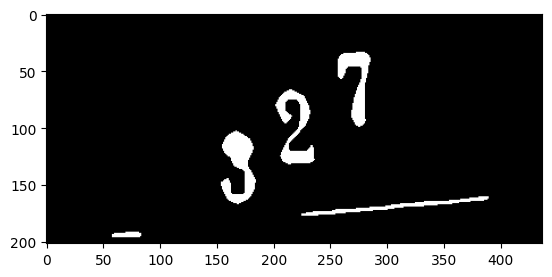

In [49]:
# Find contours from edges
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a new blank image
filled = np.zeros_like(edges)

# Fill each contour with white
# Filling Canny is used to differentiate between digits and random noise
cv2.fillPoly(filled, contours, 255)
filled = cv2.erode(filled, kernel, iterations=1)

# Display
plt.imshow(cv2.cvtColor(filled, cv2.COLOR_BGR2RGB))
plt.show()

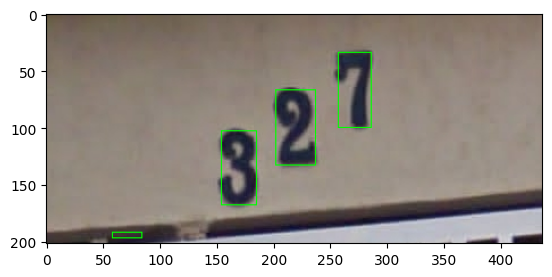

In [50]:
# Calculate total number of pixels in the image
total_pixels = image.shape[0] * image.shape[1]

# Set min and max size of bounding boxes based on pixel density
min_size = int(total_pixels * 0.0001)
max_size = int(total_pixels * 0.45)

# Set min and max aspect ratios of bounding boxes
min_aspect_ratio = 0.1
max_aspect_ratio = 5.5

contours, hierarchy = cv2.findContours(filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find bounding boxes around each digit
digit_bboxes = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    bbox_area = w * h
    aspect_ratio = float(w) / h
    touching_bounds = (x == 0 or y == 0 or x+w == image.shape[1] or y+h == image.shape[0])
    if bbox_area > min_size and bbox_area < max_size and aspect_ratio > min_aspect_ratio and aspect_ratio < max_aspect_ratio and not touching_bounds:
        digit_bboxes.append((x, y, x+w, y+h))

# Draw bounding boxes on the original image
image_with_boxes = image.copy()
for bbox in digit_bboxes:
    cv2.rectangle(image_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)

# Display
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.show()